In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [3]:
sns.set_style('darkgrid')

In [4]:
train = pd.read_csv('train.csv', na_values=['?','Error',-999,-1])
test = pd.read_csv('test.csv', na_values = ['?','Error',-999,-1])

In [28]:
combined = pd.concat([train,test], axis = 0, ignore_index = True )

In [29]:
combined.tail()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
56906,fffe43004900440035003600330037003800,Kraig Peele,12,M,2V0HA0O,NaN,Gold Membership,2015-01-25,No,xxxxxxxx,...,103.57,46279.35,18.0,708.120000,No,Yes,No,Not Applicable,Poor Product Quality,NaN
56907,fffe43004900440032003900370037003100,Damaris Sabol,40,F,VJGQD6Q,Village,No Membership,2017-12-31,Yes,CID45490,...,63.19,23466.26,NaN,574.340000,No,Yes,No,Not Applicable,No reason specified,NaN
56908,fffe43004900440036003100310036003700,Loura Huckstep,55,M,ADE7LWA,Town,No Membership,2015-09-09,No,xxxxxxxx,...,68.72,17903.75,24.0,564.300000,No,Yes,Yes,Unsolved,No reason specified,NaN
56909,fffe43004900440034003200330033003600,Sharita Clubb,17,F,A35KUBS,City,Silver Membership,2016-04-17,Yes,CID37167,...,119.54,14057.09,22.0,606.340000,No,Yes,No,Not Applicable,Poor Website,NaN
56910,fffe43004900440036003200340030003100,Ying Branum,20,M,IPJKJJV,Town,Premium Membership,2017-10-30,Yes,CID56352,...,505.26,36786.44,NaN,1193.689813,No,Yes,Yes,Unsolved,Too many ads,NaN


In [30]:
df_num = [feature for feature in combined.columns if combined[feature].dtypes != 'O']
df_discrete=[feature for feature in df_num if len(combined[feature].unique())<25]
df_cont = [feature for feature in df_num if feature not in df_discrete]
df_cat = [feature for feature in combined.columns if feature not in df_num]
print("Numerical Features Count {}".format(len(df_num)))
print("Discrete feature Count {}".format(len(df_discrete)))
print("Continuous feature Count {}".format(len(df_cont)))
print("Categorical feature Count {}".format(len(df_cat)))

Numerical Features Count 7
Discrete feature Count 1
Continuous feature Count 6
Categorical feature Count 18


In [31]:
df_cat.remove('joining_date')
df_cat.remove('last_visit_time')
df_cat.remove('customer_id')
df_cat.remove('Name')
df_cat.remove('security_no')
df_cat.remove('referral_id')

In [32]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56911 entries, 0 to 56910
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   56911 non-null  object 
 1   Name                          56911 non-null  object 
 2   age                           56911 non-null  int64  
 3   gender                        56911 non-null  object 
 4   security_no                   56911 non-null  object 
 5   region_category               48535 non-null  object 
 6   membership_category           56911 non-null  object 
 7   joining_date                  56911 non-null  object 
 8   joined_through_referral       48475 non-null  object 
 9   referral_id                   56911 non-null  object 
 10  preferred_offer_types         56464 non-null  object 
 11  medium_of_operation           48554 non-null  object 
 12  internet_option               56911 non-null  object 
 13  l

In [17]:
combined[df_cat]

,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,NaN,Wi-Fi,Yes,Yes,No,Not Applicable,Products always in Stock
1,F,City,Premium Membership,NaN,Gift Vouchers/Coupons,Desktop,Mobile_Data,Yes,No,Yes,Solved,Quality Customer Care
2,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,No,Yes,Yes,Solved in Follow-up,Poor Website
3,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,No,Yes,Yes,Unsolved,Poor Website
4,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,No,Yes,Yes,Solved,Poor Website
...,...,...,...,...,...,...,...,...,...,...,...,...
19914,M,NaN,Gold Membership,No,Without Offers,Desktop,Fiber_Optic,No,Yes,No,Not Applicable,Poor Product Quality
19915,F,Village,No Membership,Yes,Without Offers,Desktop,Fiber_Optic,No,Yes,No,Not Applicable,No reason specified
19916,M,Town,No Membership,No,Credit/Debit Card Offers,Desktop,Mobile_Data,No,Yes,Yes,Unsolved,No reason specified
19917,F,City,Silver Membership,Yes,Credit/Debit Card Offers,Smartphone,Fiber_Optic,No,Yes,No,Not Applicable,Poor Website


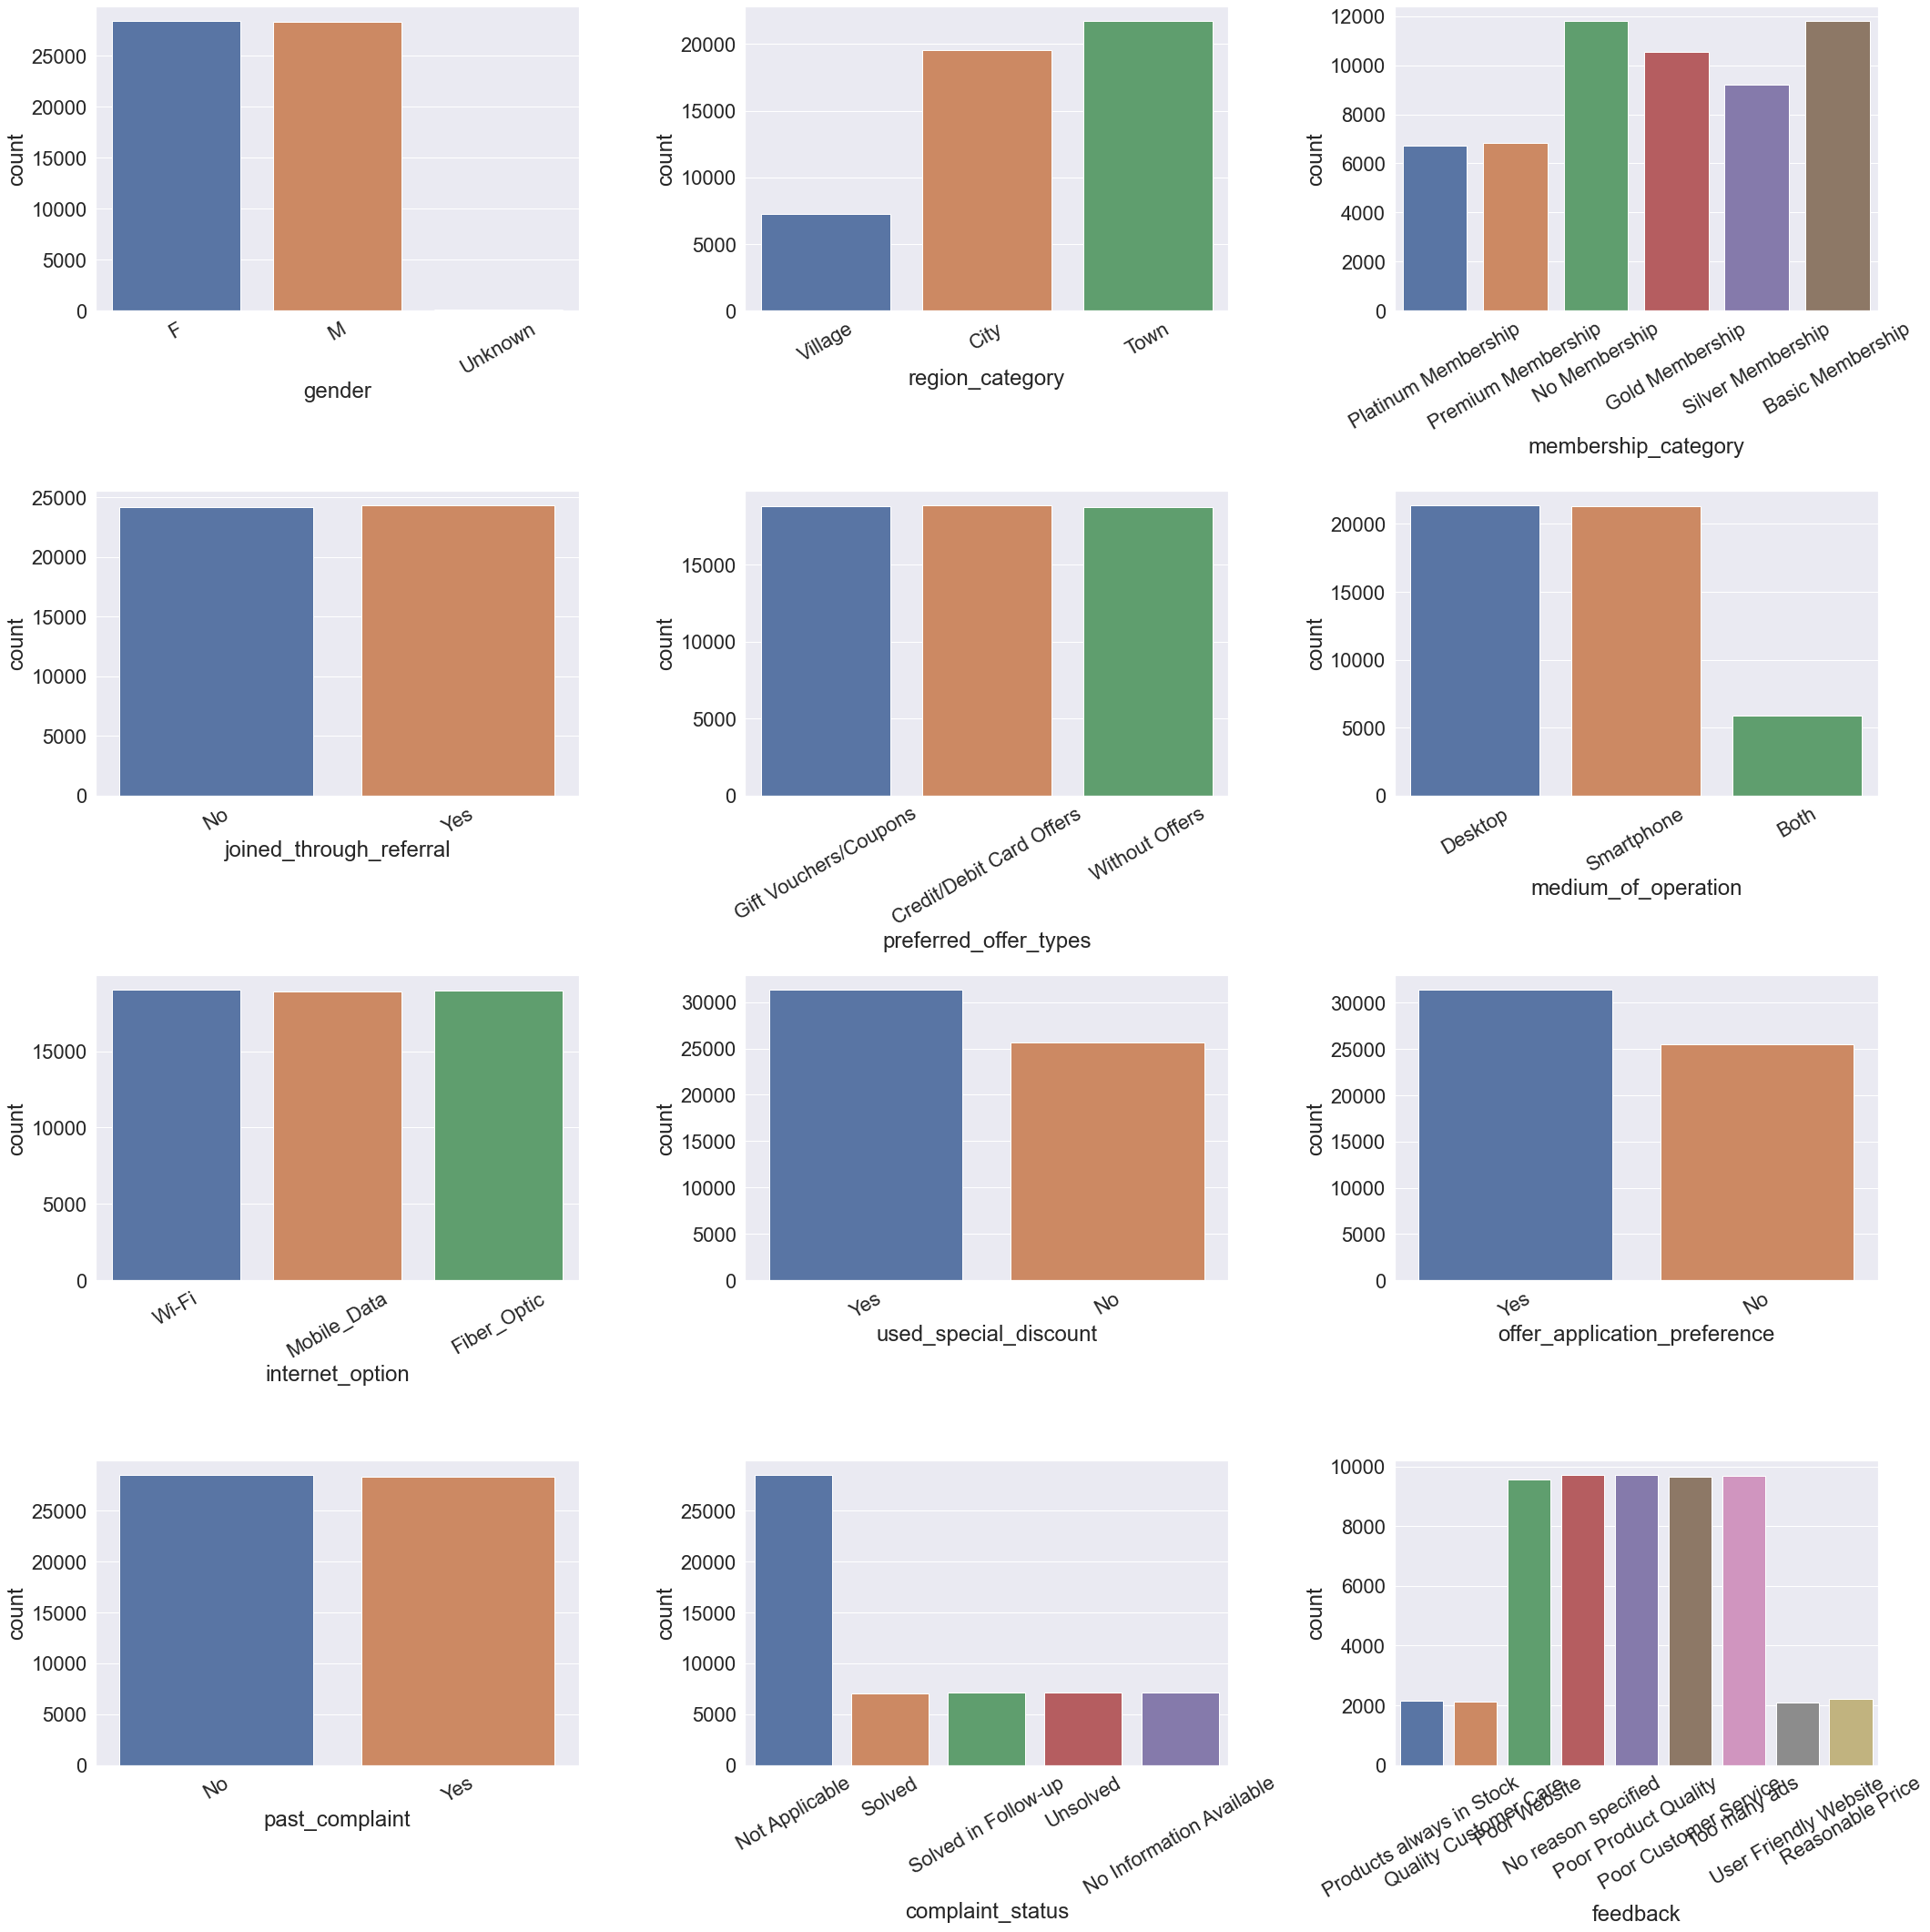

In [18]:
plt.figure(figsize=(30,30))
for index,col in enumerate(df_cat,1):
    sns.set(font_scale = 2)
    plt.subplot(4,3,index)
    ax = sns.countplot(combined[col])
    plt.xticks(rotation=30)
#     ax.set_yticklabels(ax.get_yticks(), size = 20)
#     plt.xlabel(col, size = 22)
#     plt.ylabel('Count', size = 22)
plt.tight_layout()
plt.show()

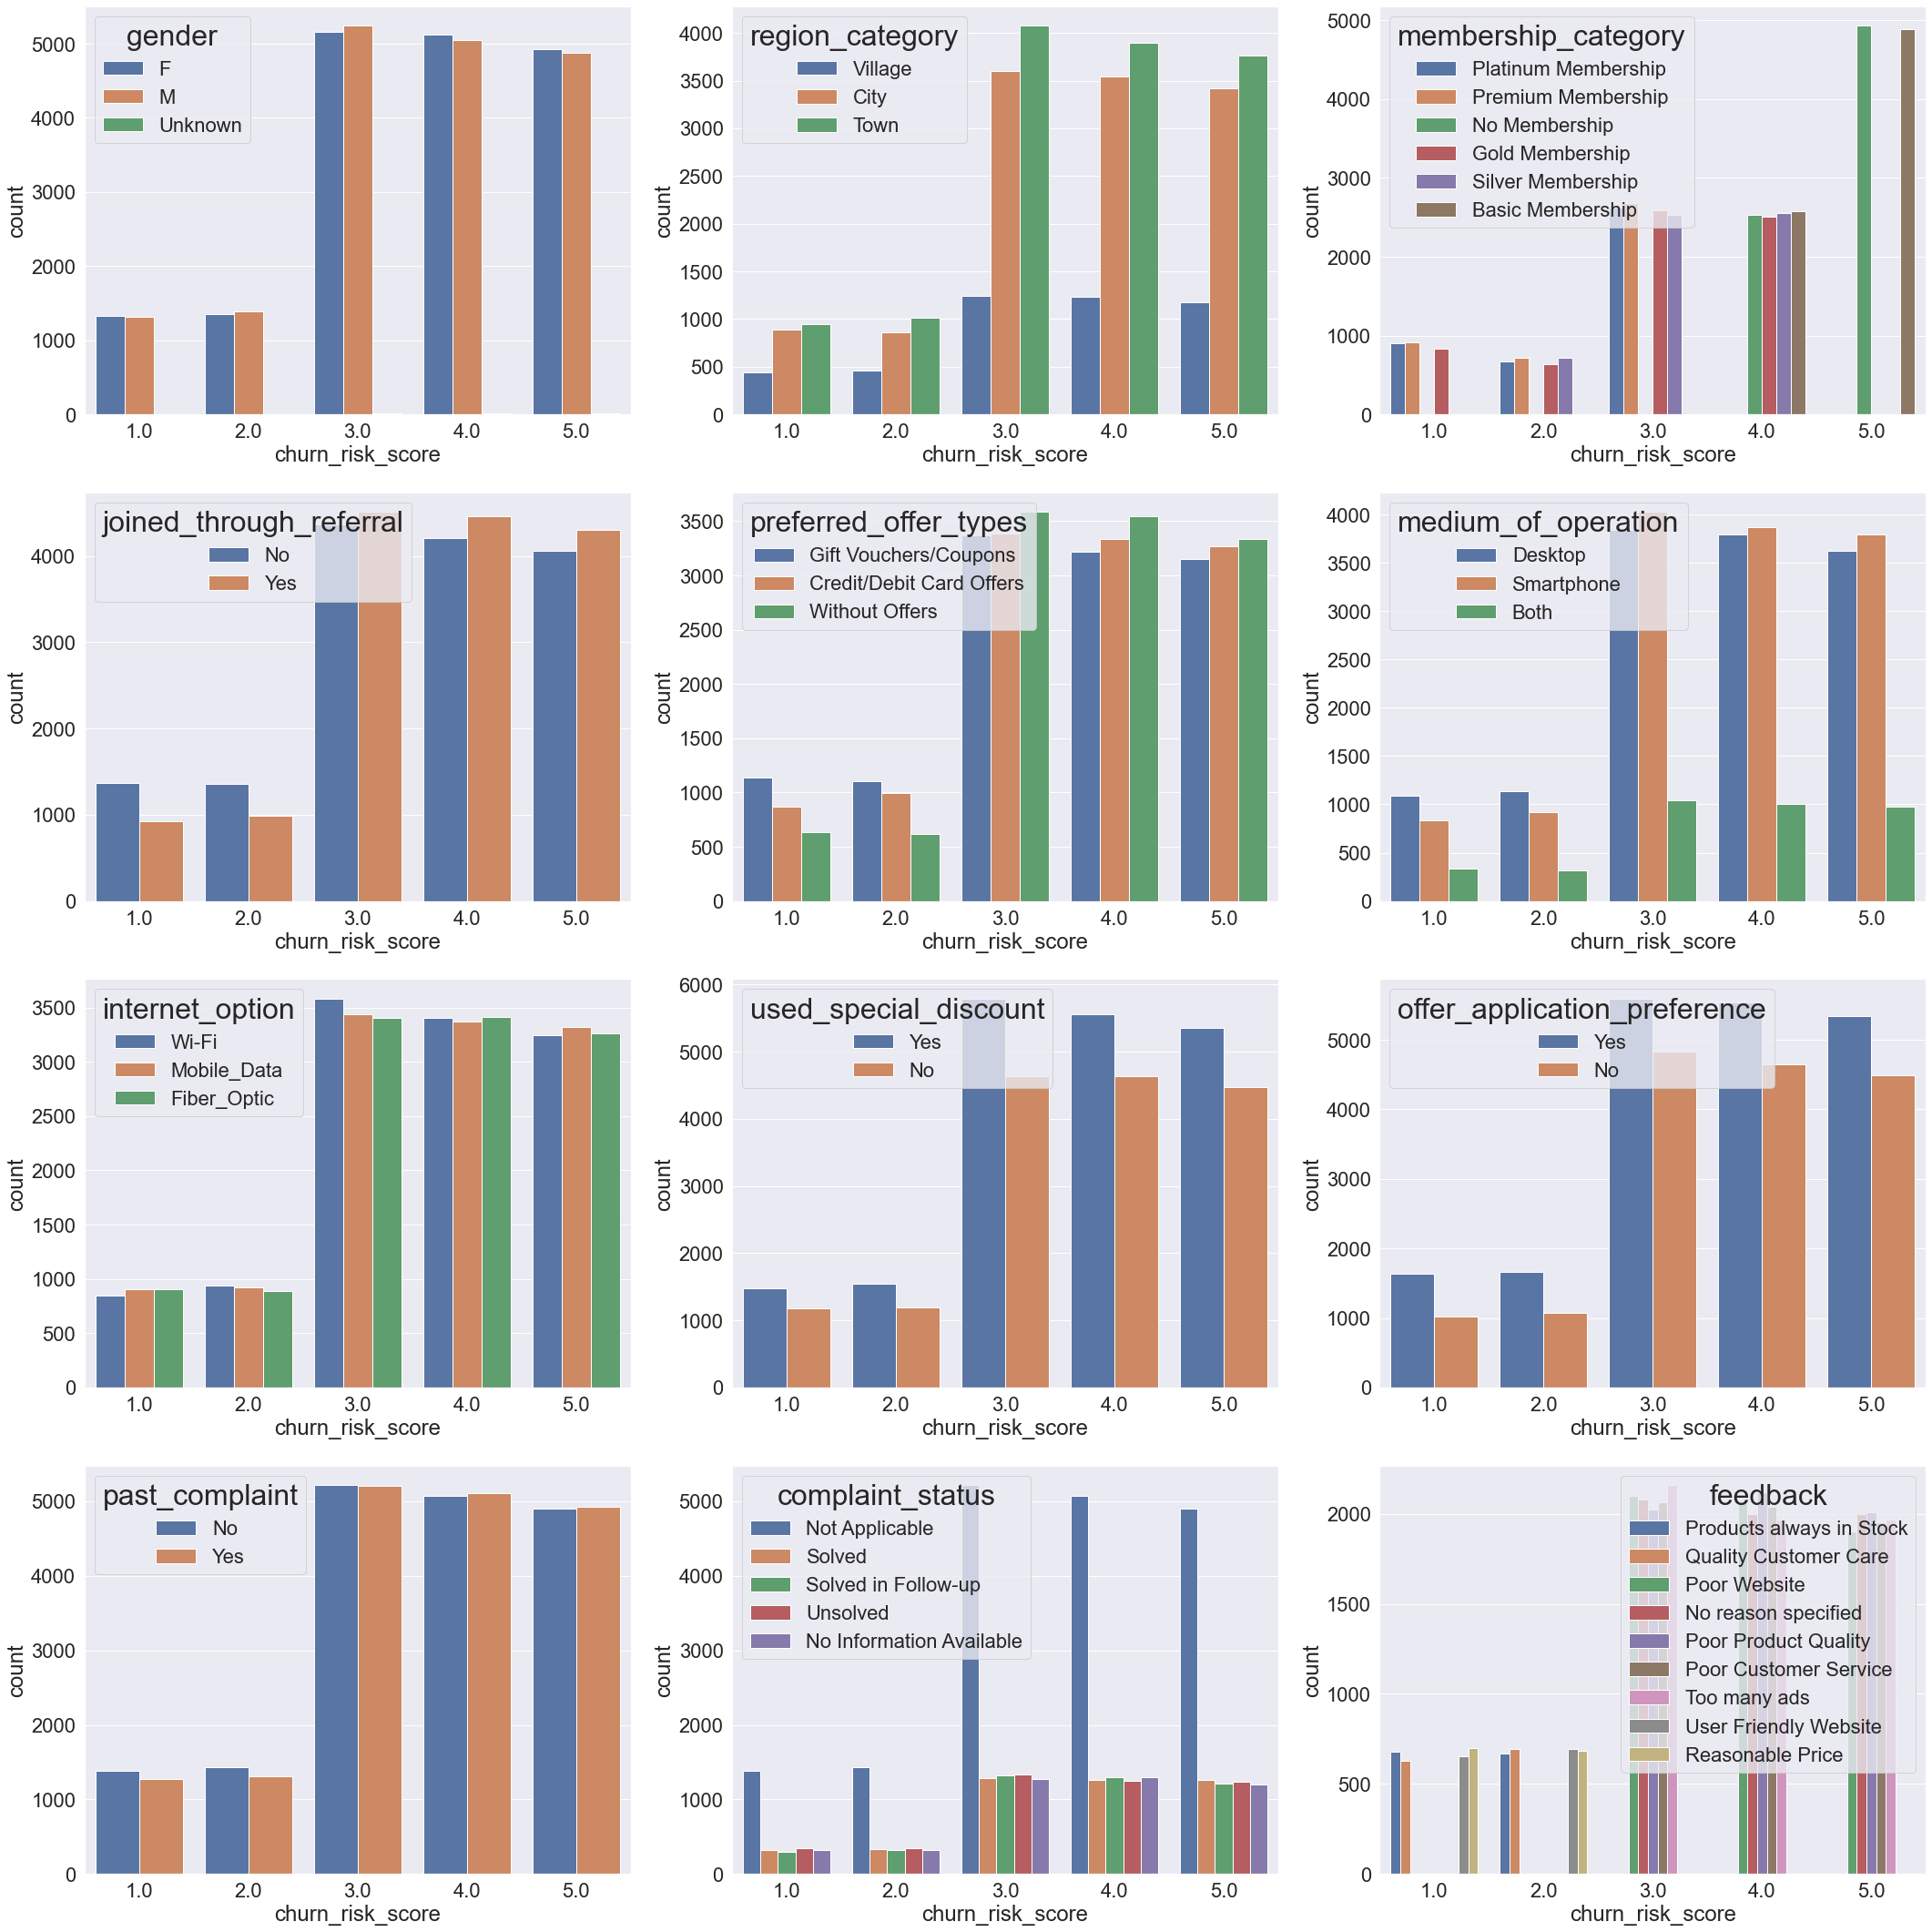

In [19]:
plt.figure(figsize=(30,30))
for index,col in enumerate(df_cat,1):
    sns.set(font_scale=2)
    plt.subplot(4,3,index)
    ax = sns.countplot(combined['churn_risk_score'], hue = combined[col])
    plt.setp(ax.get_legend().get_title(), fontsize='32') 

plt.tight_layout()
plt.show()

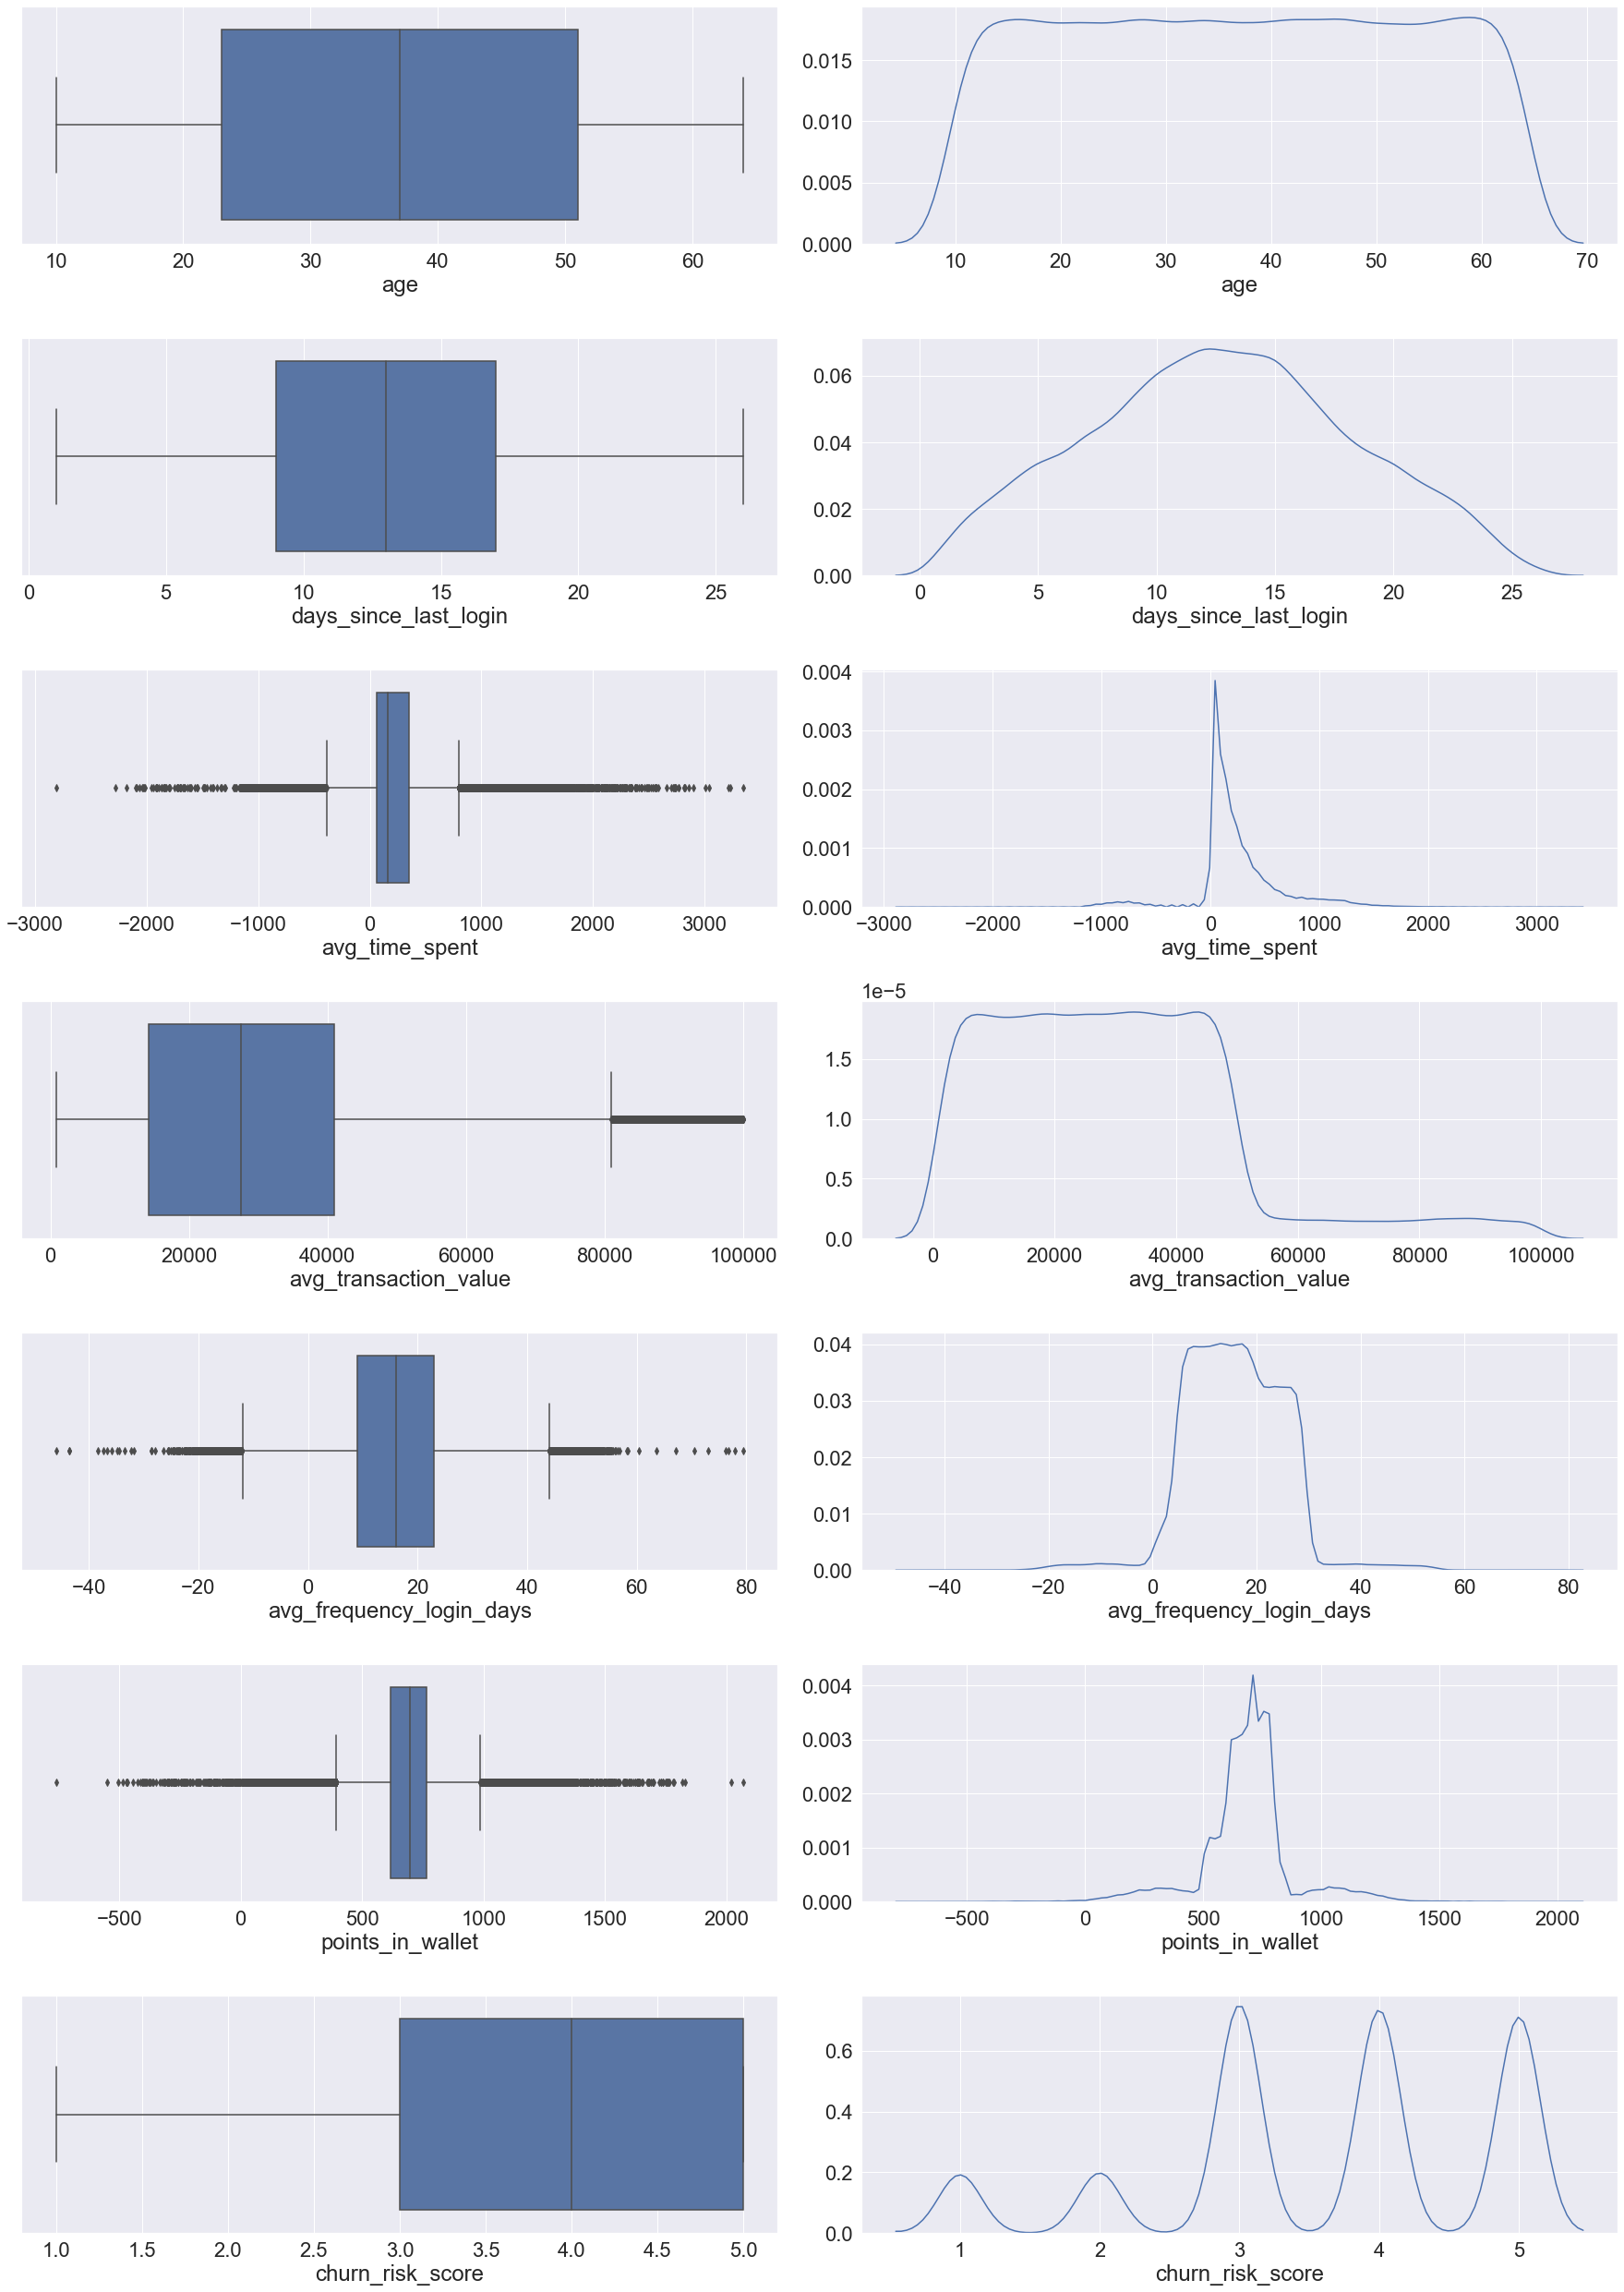

In [20]:
plt.figure(figsize=(25,35))
index = 1
for col in df_num:
    sns.set(font_scale = 2)
    plt.subplot(7,2,index)
    sns.boxplot(combined[col])
    plt.subplot(7,2,index+1)
    sns.distplot(combined[col], hist = False)
    index = index + 2
plt.tight_layout()
plt.show()

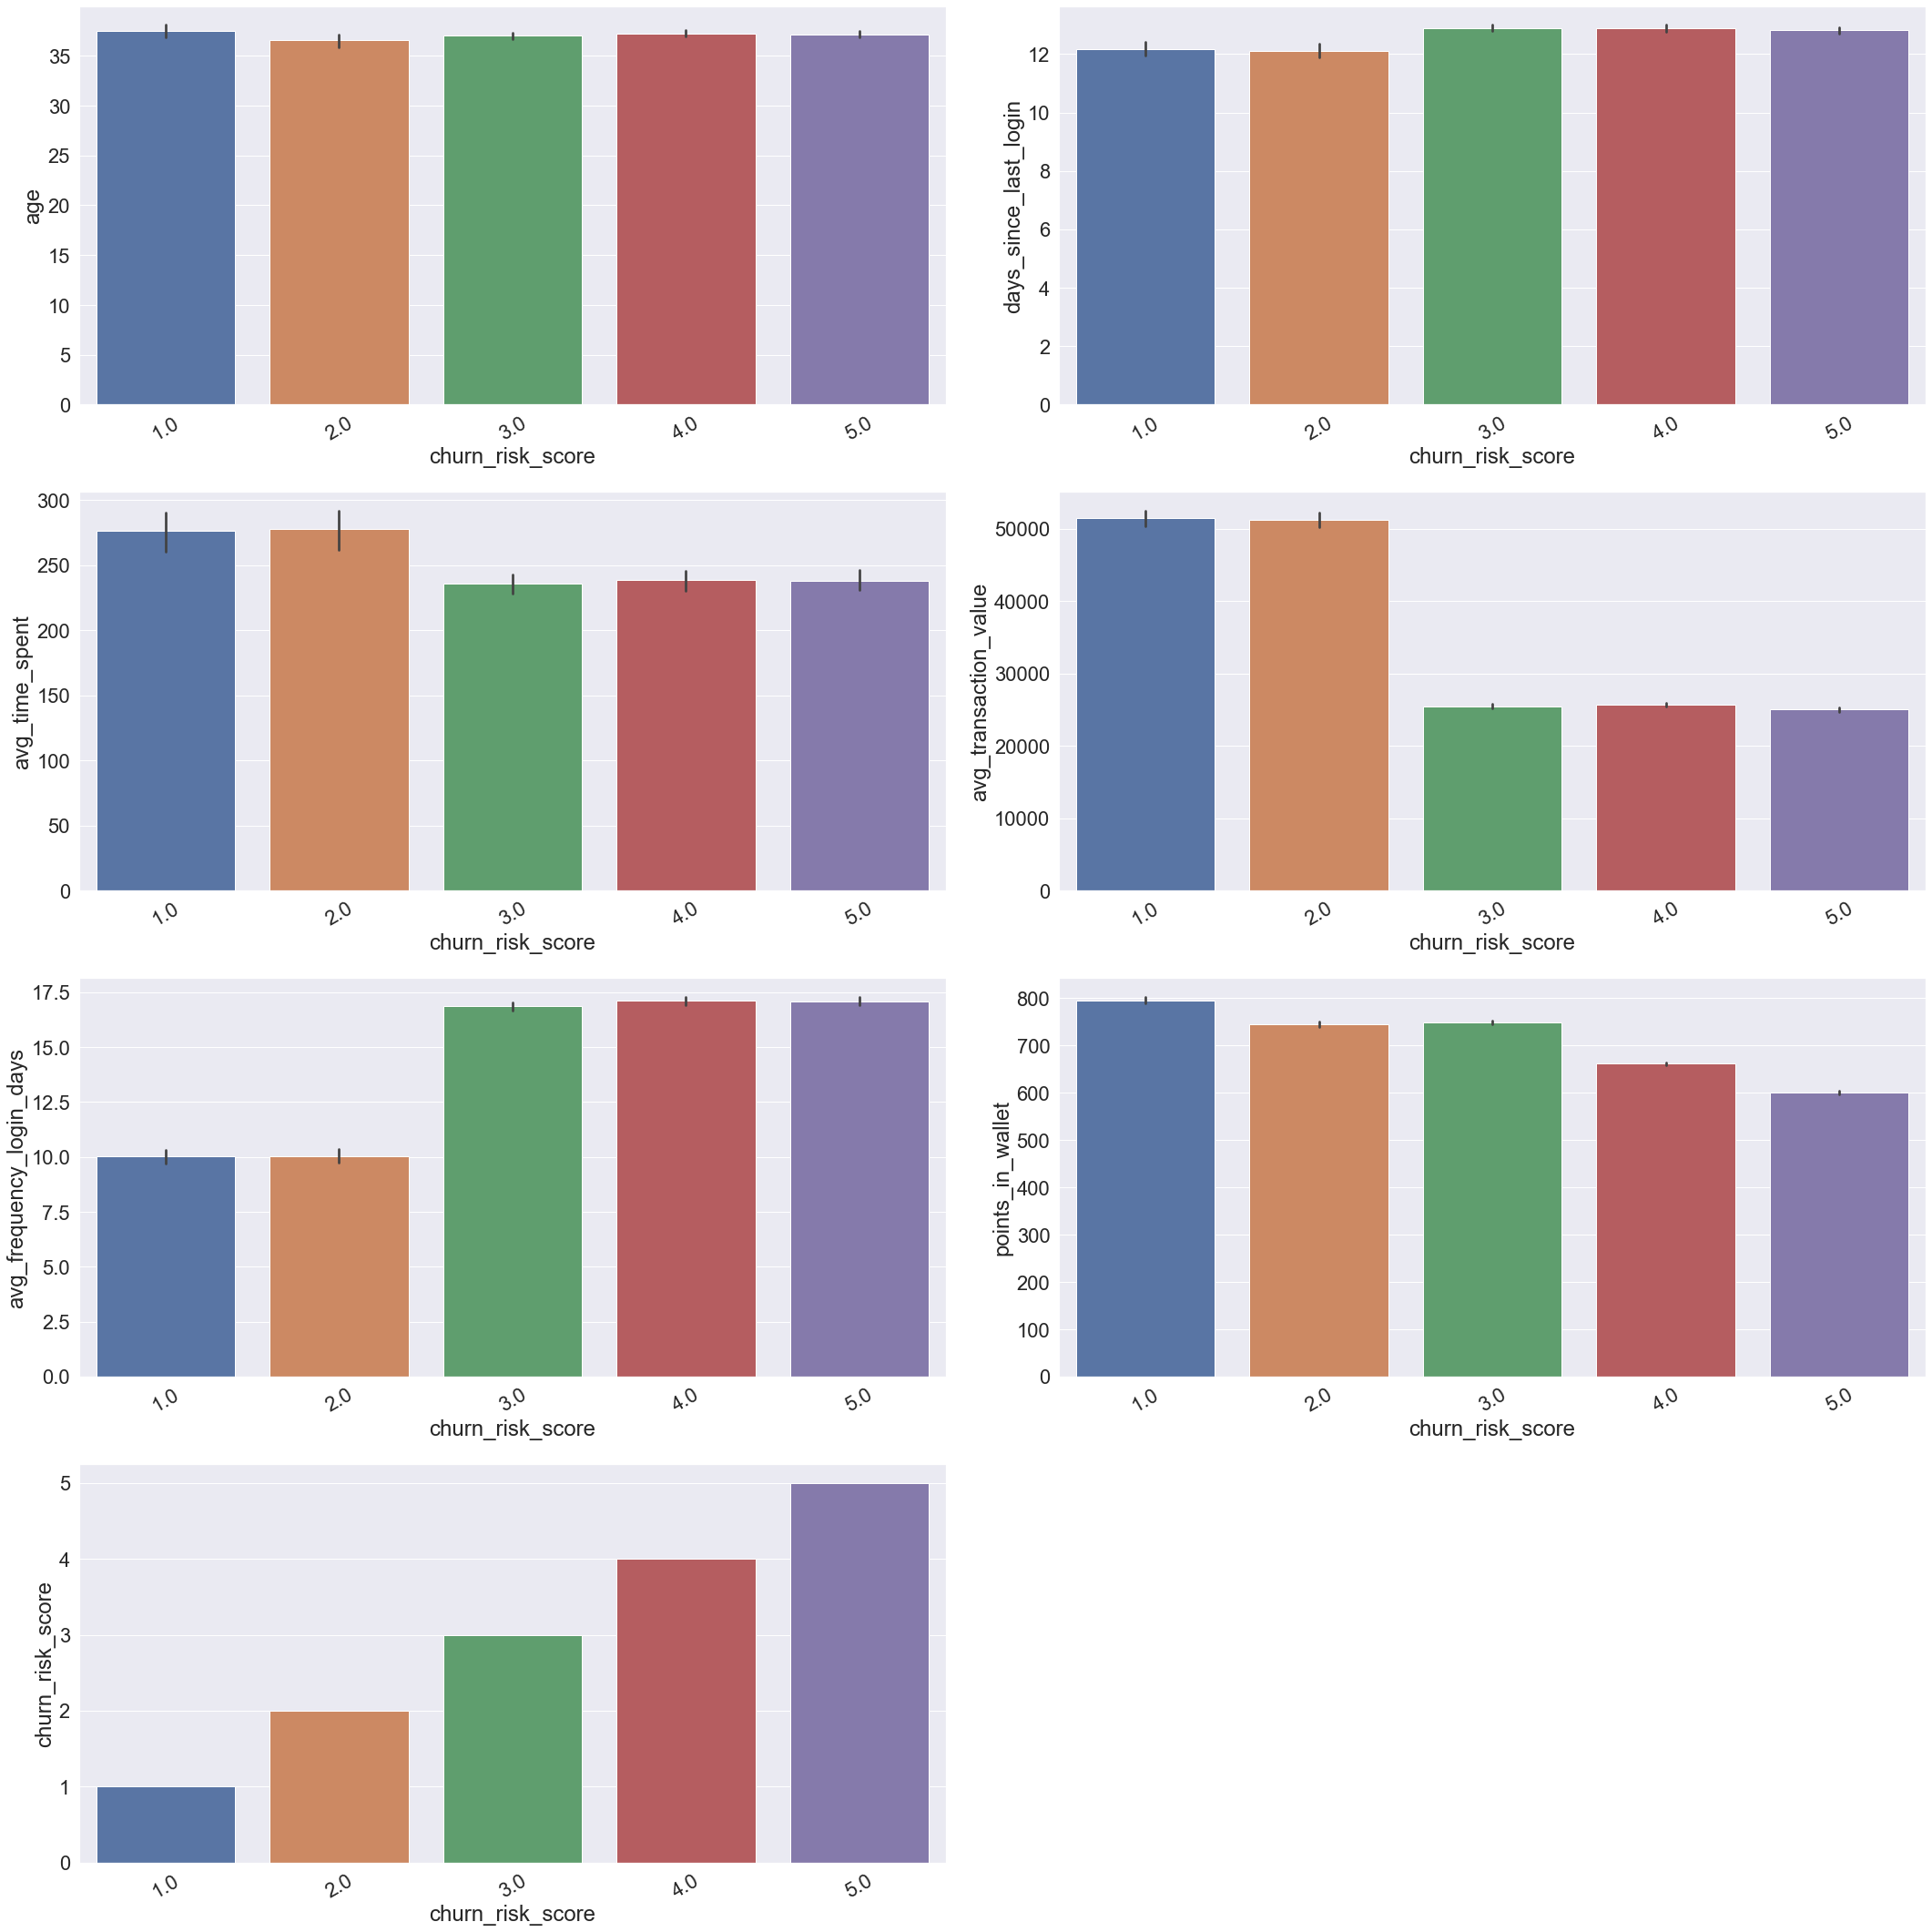

In [21]:
plt.figure(figsize=(30,30))
for index,col in enumerate(df_num,1):
    sns.set(font_scale = 2)
    plt.subplot(4,2,index)
    ax = sns.barplot(combined['churn_risk_score'], y=combined[col])
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [33]:
df = combined[combined['avg_time_spent'] < 0]
df['avg_time_spent'] = np.nan
combined.loc[df['avg_time_spent'].index,'avg_time_spent'] = df['avg_time_spent']

<ipython-input-33-dc04c4f1a200>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_time_spent'] = np.nan


In [35]:
df = combined[combined['avg_frequency_login_days'] < 0]
df['avg_frequency_login_days'] = np.nan
combined.loc[df['avg_frequency_login_days'].index,'avg_frequency_login_days'] = df['avg_frequency_login_days']

<ipython-input-35-5224b1df7d94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_frequency_login_days'] = np.nan


In [36]:
df = combined[combined['points_in_wallet'] < 0]
df['points_in_wallet'] = np.nan
combined.loc[df['points_in_wallet'].index,'points_in_wallet'] = df['points_in_wallet']

<ipython-input-36-17b48ff80672>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['points_in_wallet'] = np.nan


In [37]:
mydict = {'Unknown':np.nan}
combined['gender'] = combined['gender'].replace(mydict)

In [38]:
mydict = {'No Information Available':np.nan}
combined['complaint_status'] = combined['complaint_status'].replace(mydict)

In [39]:
combined.isnull().sum() / len(train) * 100

customer_id                      0.000000
Name                             0.000000
age                              0.000000
gender                           0.256812
security_no                      0.000000
region_category                 22.642734
membership_category              0.000000
joining_date                     0.000000
joined_through_referral         22.804931
referral_id                      0.000000
preferred_offer_types            1.208369
medium_of_operation             22.591371
internet_option                  0.000000
last_visit_time                  0.000000
days_since_last_login            8.166631
avg_time_spent                   7.163711
avg_transaction_value            0.000000
avg_frequency_login_days        17.611916
points_in_wallet                15.146518
used_special_discount            0.000000
offer_application_preference     0.000000
past_complaint                   0.000000
complaint_status                19.193339
feedback                         0

### NULL value imputation

#### Gender

In [42]:
combined['gender'].value_counts()

F    28462
M    28354
Name: gender, dtype: int64

In [43]:
combined['gender'] = combined['gender'].fillna(combined['gender'].mode()[0])
combined['days_since_last_login'] = combined['days_since_last_login'].fillna(combined['days_since_last_login'].mean())
combined['avg_time_spent'] = combined['avg_time_spent'].fillna(combined['avg_time_spent'].mean())
combined['churn_risk_score'] = combined['churn_risk_score'].fillna(combined['churn_risk_score'].mode()[0])
combined['complaint_status'] = combined['complaint_status'].fillna(combined['complaint_status'].mode()[0])


In [44]:
temp = combined.groupby('region_category')['churn_risk_score'].value_counts().unstack()
temp

churn_risk_score,1.0,2.0,3.0,4.0,5.0
region_category,,,,,
City,890,860,10810,3547,3422
Town,949,1017,12139,3899,3759
Village,438,462,3937,1231,1175


In [45]:
temp.iloc[:,1].sort_values(ascending = False).index[0]

'Town'

In [46]:
null_ind = combined[combined['region_category'].isnull()].index
for i in null_ind:
    if combined.loc[i,'churn_risk_score'] == 1.0:
        combined.loc[i,'region_category'] = temp.iloc[:,0].sort_values(ascending = False).index[0]
    elif combined.loc[i,'churn_risk_score'] == 2.0:
        combined.loc[i,'region_category'] = temp.iloc[:,1].sort_values(ascending = False).index[0]
    elif combined.loc[i,'churn_risk_score'] == 3.0:
        combined.loc[i,'region_category'] = temp.iloc[:,2].sort_values(ascending = False).index[0]
    elif combined.loc[i,'churn_risk_score'] == 4.0:
        combined.loc[i,'region_category'] = temp.iloc[:,3].sort_values(ascending = False).index[0]
    else:
        combined.loc[i,'region_category'] = temp.iloc[:,4].sort_values(ascending = False).index[0]
    

In [47]:
combined['region_category'].value_counts()

Town       30139
City       19529
Village     7243
Name: region_category, dtype: int64

In [48]:
combined[combined['joined_through_referral'].isnull()]['referral_id'].value_counts()

xxxxxxxx    871
CID63748      6
CID16200      6
CID52976      5
CID37714      5
           ... 
CID3091       1
CID31338      1
CID3408       1
CID3849       1
CID49698      1
Name: referral_id, Length: 5964, dtype: int64

In [49]:
null_ind = combined[combined['joined_through_referral'].isnull()].index
for i in null_ind:
    if combined.loc[i,'referral_id'] == 'xxxxxxxx':
        combined.loc[i,'joined_through_referral'] = 'No'
    else:
        combined.loc[i,'joined_through_referral'] = 'Yes'
    

In [50]:
combined['preferred_offer_types'] = combined['preferred_offer_types'].fillna(combined['preferred_offer_types'].mode()[0])

In [51]:
df1 = combined.drop(['avg_frequency_login_days','complaint_status','points_in_wallet','joining_date','last_visit_time','customer_id','Name','security_no','referral_id'],1)

In [52]:
mydict = {'Platinum Membership':5, 'Premium Membership':4, 'No Membership':0,
       'Gold Membership':3, 'Silver Membership':2, 'Basic Membership':1}
df1['membership_category'] = df1['membership_category'].replace(mydict)

In [53]:
mydict = {'Desktop':0, 'Smartphone':1, 'Both':2}
df1['medium_of_operation'] = df1['medium_of_operation'].replace(mydict)

In [54]:
mydict = {'Poor Product Quality':1,'No reason specified':0,'Too many ads':1,'Poor Website':1,'Poor Customer Service':1,'Reasonable Price':2,'User Friendly Website':2,'Products always in Stock':2,'Quality Customer Care':2}
df1['feedback'] = df1['feedback'].replace(mydict)

In [55]:
df1 = pd.get_dummies(df1, drop_first = True)

In [56]:
X_train = df1[~df1['medium_of_operation'].isnull()].drop('medium_of_operation',1)
y_train = df1[~df1['medium_of_operation'].isnull()]['medium_of_operation']
X_test = df1[df1['medium_of_operation'].isnull()].drop('medium_of_operation',1)

In [57]:
model = RandomForestClassifier(random_state = 0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [58]:
X_test['medium_of_operation'] = y_pred

In [59]:
mydict = {0:'Desktop', 1:'Smartphone', 2:'Both'}
X_test['medium_of_operation'] = X_test['medium_of_operation'].replace(mydict)

In [60]:
combined.loc[X_test['medium_of_operation'].index,'medium_of_operation'] = X_test['medium_of_operation'] 

In [61]:
df1 = combined.drop(['complaint_status','points_in_wallet','joining_date','last_visit_time','customer_id','Name','security_no','referral_id'],1)

mydict = {'Platinum Membership':5, 'Premium Membership':4, 'No Membership':0,
       'Gold Membership':3, 'Silver Membership':2, 'Basic Membership':1}
df1['membership_category'] = df1['membership_category'].replace(mydict)

mydict = {'Desktop':0, 'Smartphone':1, 'Both':2}
df1['medium_of_operation'] = df1['medium_of_operation'].replace(mydict)

mydict = {'Poor Product Quality':1,'No reason specified':0,'Too many ads':1,'Poor Website':1,'Poor Customer Service':1,'Reasonable Price':2,'User Friendly Website':2,'Products always in Stock':2,'Quality Customer Care':2}
df1['feedback'] = df1['feedback'].replace(mydict)

df1 = pd.get_dummies(df1, drop_first = True)

In [62]:
X_train = df1[~df1['avg_frequency_login_days'].isnull()].drop('avg_frequency_login_days',1)
y_train = df1[~df1['avg_frequency_login_days'].isnull()]['avg_frequency_login_days']
X_test = df1[df1['avg_frequency_login_days'].isnull()].drop('avg_frequency_login_days',1)
model = RandomForestRegressor(random_state = 0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
X_test['avg_frequency_login_days'] = y_pred
combined.loc[X_test['avg_frequency_login_days'].index,'avg_frequency_login_days'] = X_test['avg_frequency_login_days'] 

In [63]:
df1 = combined.drop(['complaint_status','joining_date','last_visit_time','customer_id','Name','security_no','referral_id'],1)

mydict = {'Platinum Membership':5, 'Premium Membership':4, 'No Membership':0,
       'Gold Membership':3, 'Silver Membership':2, 'Basic Membership':1}
df1['membership_category'] = df1['membership_category'].replace(mydict)

mydict = {'Desktop':0, 'Smartphone':1, 'Both':2}
df1['medium_of_operation'] = df1['medium_of_operation'].replace(mydict)

mydict = {'Poor Product Quality':1,'No reason specified':0,'Too many ads':1,'Poor Website':1,'Poor Customer Service':1,'Reasonable Price':2,'User Friendly Website':2,'Products always in Stock':2,'Quality Customer Care':2}
df1['feedback'] = df1['feedback'].replace(mydict)

df1 = pd.get_dummies(df1, drop_first = True)

In [64]:
X_train = df1[~df1['points_in_wallet'].isnull()].drop('points_in_wallet',1)
y_train = df1[~df1['points_in_wallet'].isnull()]['points_in_wallet']
X_test = df1[df1['points_in_wallet'].isnull()].drop('points_in_wallet',1)
model = RandomForestRegressor(random_state = 0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
X_test['points_in_wallet'] = y_pred
combined.loc[X_test['points_in_wallet'].index,'points_in_wallet'] = X_test['points_in_wallet'] 

In [65]:
### outliers

for feat in ['avg_time_spent','avg_transaction_value','avg_frequency_login_days','points_in_wallet']:
    combined[feat] = combined[feat].clip(lower = combined[feat].quantile(0.025), upper=combined[feat].quantile(0.975))
    

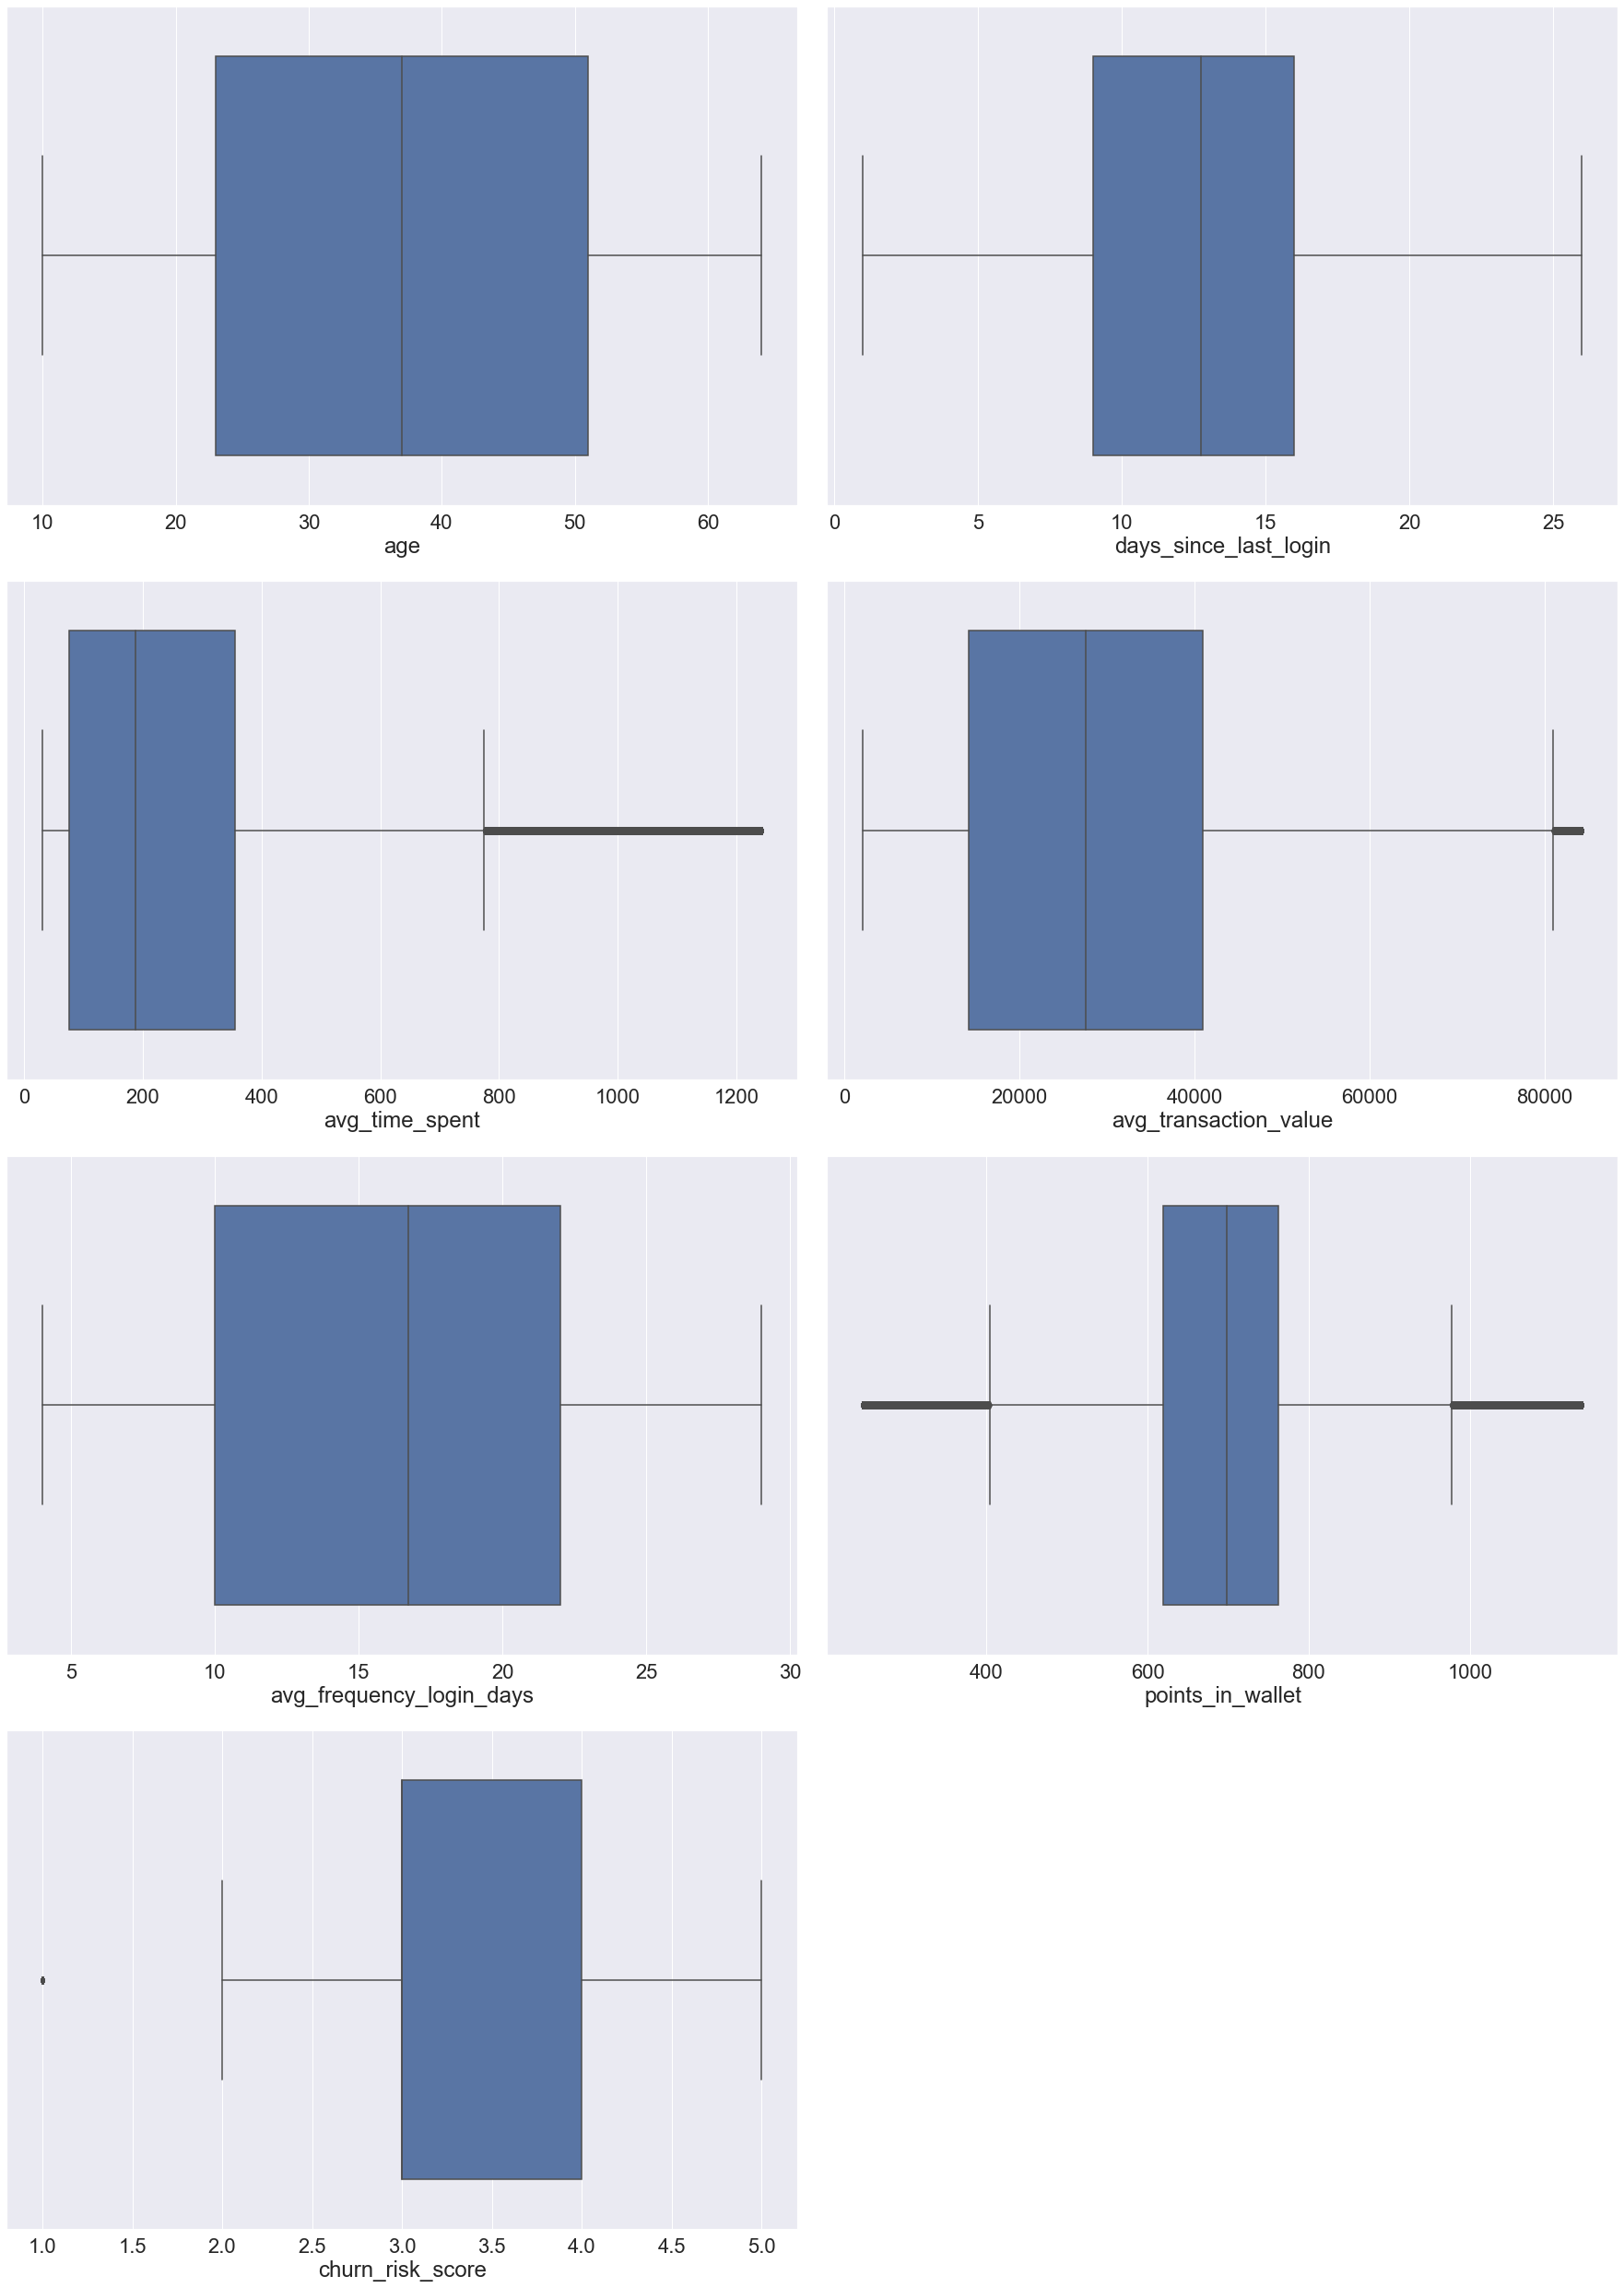

In [66]:
plt.figure(figsize=(25,35))
for index,col in enumerate(df_num,1):
    sns.set(font_scale = 2)
    plt.subplot(4,2,index)
    sns.boxplot(combined[col])
plt.tight_layout()
plt.show()

In [67]:
mydict = {'Platinum Membership':5, 'Premium Membership':4, 'No Membership':0,
       'Gold Membership':3, 'Silver Membership':2, 'Basic Membership':1}
combined['membership_category'] = combined['membership_category'].replace(mydict)

mydict = {'Desktop':0, 'Smartphone':1, 'Both':2}
combined['medium_of_operation'] = combined['medium_of_operation'].replace(mydict)

mydict = {'Poor Product Quality':1,'No reason specified':0,'Too many ads':1,'Poor Website':1,'Poor Customer Service':1,'Reasonable Price':2,'User Friendly Website':2,'Products always in Stock':2,'Quality Customer Care':2}
combined['feedback'] = combined['feedback'].replace(mydict)



In [68]:
combined = pd.get_dummies(data=combined,columns=['gender','region_category','joined_through_referral','preferred_offer_types','internet_option','used_special_discount','offer_application_preference','past_complaint','complaint_status'],drop_first = True)

In [69]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(combined[df_num].drop('churn_risk_score',1))
encoded = sc.transform(combined[df_num].drop('churn_risk_score',1))


In [70]:
combined = combined.drop(df_num[:-1],1)

In [71]:
combined.head()

,customer_id,Name,security_no,membership_category,joining_date,referral_id,medium_of_operation,last_visit_time,feedback,churn_risk_score,...,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,internet_option_Mobile_Data,internet_option_Wi-Fi,used_special_discount_Yes,offer_application_preference_Yes,past_complaint_Yes,complaint_status_Solved,complaint_status_Solved in Follow-up,complaint_status_Unsolved
0,fffe4300490044003600300030003800,Pattie Morrisey,XW0DQ7H,5,2017-08-17,xxxxxxxx,0,16:08:02,2,2.0,...,1,0,0,1,1,1,0,0,0,0
1,fffe43004900440032003100300035003700,Traci Peery,5K0N3X1,4,2017-08-28,CID21329,0,12:38:13,2,1.0,...,1,0,1,0,1,0,1,1,0,0
2,fffe4300490044003100390032003600,Merideth Mcmeen,1F2TCL3,0,2016-11-11,CID12313,0,22:53:21,1,5.0,...,1,0,0,1,0,1,1,0,1,0
3,fffe43004900440036003000330031003600,Eufemia Cardwell,VJGJ33N,0,2016-10-29,CID3793,0,15:57:50,1,5.0,...,1,0,1,0,0,1,1,0,0,1
4,fffe43004900440031003900350030003600,Meghan Kosak,SVZXCWB,0,2017-09-12,xxxxxxxx,1,15:46:44,1,5.0,...,0,0,1,0,0,1,1,1,0,0


In [72]:
encoded = pd.DataFrame(encoded, columns = df_num[:-1])
combined = pd.concat([combined,encoded],axis=1 )

In [75]:
## drop unwanted columns

combined = combined.drop(['customer_id','Name','security_no','joining_date','referral_id','last_visit_time'], axis = 1)

In [76]:
combined.head()

,membership_category,medium_of_operation,feedback,churn_risk_score,gender_M,region_category_Town,region_category_Village,joined_through_referral_Yes,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,...,past_complaint_Yes,complaint_status_Solved,complaint_status_Solved in Follow-up,complaint_status_Unsolved,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
0,5,0,2,2.0,0,0,1,0,1,0,...,0,0,0,0,-1.198385,0.789316,0.051112,1.268804,0.092736,0.571478
1,4,0,2,1.0,0,0,0,1,1,0,...,1,1,0,0,-0.317051,0.604252,0.070408,-0.864014,-0.885583,0.790954
2,0,0,1,5.0,0,1,0,1,1,0,...,1,0,1,0,0.438378,0.234124,0.779466,-0.429207,0.791536,-1.160454
3,0,0,1,5.0,1,0,0,1,1,0,...,1,0,0,1,-0.002289,-0.321069,-0.784808,-0.205525,-1.444623,-0.747776
4,0,1,1,5.0,0,0,0,0,0,0,...,1,1,0,0,-0.380003,1.344508,-0.582519,-0.245662,-0.047024,-0.159907


In [78]:
train.shape

(36992, 25)

In [81]:
train_final = combined.iloc[:36992,:]
test_final = combined.iloc[36992:,:]

In [86]:
test_final = test_final.drop('churn_risk_score',1)

In [89]:
test_final = test_final.reset_index(drop = True)

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [93]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

In [149]:
X = train_final.drop('churn_risk_score', 1)
y = train_final['churn_risk_score']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state =0)

In [153]:
## FITTING VANILLA


ml_model = RandomForestClassifier().fit(X_train,y_train)
    
y_pred = ml_model.predict(X_test)
    
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('\n\n')

[[ 624  165    0    0    0]
 [ 210  597    0    0    0]
 [  21   14 3155  170  114]
 [   0    0  381 1759  946]
 [   0    0    0  371 2571]]
0.7844656694899982
              precision    recall  f1-score   support

         1.0       0.73      0.79      0.76       789
         2.0       0.77      0.74      0.75       807
         3.0       0.89      0.91      0.90      3474
         4.0       0.76      0.57      0.65      3086
         5.0       0.71      0.87      0.78      2942

    accuracy                           0.78     11098
   macro avg       0.77      0.78      0.77     11098
weighted avg       0.79      0.78      0.78     11098






In [111]:
# from sklearn.feature_selection import f_classif, chi2, SelectKBest

In [115]:
# df_num

['age',
 'days_since_last_login',
 'avg_time_spent',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'churn_risk_score']

In [122]:
# fs = SelectKBest(score_func=f_classif, k=3)  # first selected k = all and then decided to take 3
# fs.fit_transform(X[df_num[:-1]], y)
# fs.scores_

array([1.65079535e+00, 1.84142009e+01, 1.65013897e+01, 2.47965089e+03,
       1.07577120e+03, 1.51047276e+03])

In [123]:
# fs.pvalues_

array([1.58429094e-01, 3.96743496e-15, 1.62409588e-13, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [124]:
# cols = pd.DataFrame()
# cols['Feature'] = df_num[:-1]
# cols['Fstat'] = fs.scores_
# cols['Pvalues'] = fs.pvalues_
# cols = cols.sort_values(by = 'Fstat', axis = 0, ascending = False)
# cols

,Feature,Fstat,Pvalues
3,avg_transaction_value,2479.650891,0.000000e+00
5,points_in_wallet,1510.472758,0.000000e+00
4,avg_frequency_login_days,1075.771201,0.000000e+00
1,days_since_last_login,18.414201,3.967435e-15
2,avg_time_spent,16.501390,1.624096e-13
0,age,1.650795,1.584291e-01


In [125]:
# fs.get_support(indices = True)

array([3, 4, 5], dtype=int64)

In [137]:
# ## chi2 
# fs = SelectKBest(score_func=chi2, k=8)  # first selected k = all and then decided to take 8
# fs.fit_transform(X.drop(df_num[:-1],axis=1), y)
# fs.scores_


array([2.93210455e+04, 1.92851811e+01, 6.70457728e+03, 6.95516935e-01,
       5.70739604e+00, 7.91368621e+01, 6.56200853e+01, 1.30907793e+02,
       1.72932995e+02, 1.51819510e+00, 5.25660582e+00, 2.27447090e+00,
       4.19932322e+01, 4.32058108e+00, 1.82397045e+00, 7.43946653e+00,
       1.19432623e+00])

In [138]:
# fs.pvalues_

array([0.00000000e+00, 6.90754139e-04, 0.00000000e+00, 9.51880622e-01,
       2.22091725e-01, 2.65360911e-16, 1.90469415e-13, 2.49031516e-27,
       2.45425164e-36, 8.23413620e-01, 2.61966699e-01, 6.85420814e-01,
       1.67356034e-08, 3.64355014e-01, 7.68094015e-01, 1.14408377e-01,
       8.79031880e-01])

In [140]:
# cols = pd.DataFrame()
# cols['Feature'] = X.drop(df_num[:-1],1).columns
# cols['Fstat'] = fs.scores_
# cols['Pvalues'] = fs.pvalues_
# cols = cols.sort_values(by = 'Fstat', axis = 0, ascending = False)
# cols

,Feature,Fstat,Pvalues
0,membership_category,29321.045456,0.000000e+00
2,feedback,6704.577285,0.000000e+00
8,preferred_offer_types_Without Offers,172.932995,2.454252e-36
7,preferred_offer_types_Gift Vouchers/Coupons,130.907793,2.490315e-27
5,region_category_Village,79.136862,2.653609e-16
6,joined_through_referral_Yes,65.620085,1.904694e-13
12,offer_application_preference_Yes,41.993232,1.673560e-08
1,medium_of_operation,19.285181,6.907541e-04
15,complaint_status_Solved in Follow-up,7.439467,1.144084e-01
4,region_category_Town,5.707396,2.220917e-01


In [142]:
# fs.get_support(indices = True)

array([ 0,  1,  2,  5,  6,  7,  8, 12], dtype=int64)

In [146]:
X_sel = X[['avg_transaction_value','points_in_wallet','avg_frequency_login_days','membership_category','feedback','preferred_offer_types_Without Offers','preferred_offer_types_Gift Vouchers/Coupons'
,'region_category_Village'
,'joined_through_referral_Yes'
,'offer_application_preference_Yes'
,'medium_of_operation']]
y_sel = y

In [147]:
# X_train, X_test, y_train, y_test = train_test_split(X_sel,y_sel, test_size = 0.3, random_state =0)

In [148]:
# ml_model = RandomForestClassifier().fit(X_train,y_train)
    
# y_pred = ml_model.predict(X_test)
    
# print(confusion_matrix(y_test,y_pred))
# print(accuracy_score(y_test,y_pred))
# print(classification_report(y_test,y_pred))
# print('\n\n')

[[ 622  167    0    0    0]
 [ 220  587    0    0    0]
 [  21   14 3076  262  101]
 [   0    0  315 1900  871]
 [   0    0    1  546 2395]]
0.7731122724815283
              precision    recall  f1-score   support

         1.0       0.72      0.79      0.75       789
         2.0       0.76      0.73      0.75       807
         3.0       0.91      0.89      0.90      3474
         4.0       0.70      0.62      0.66      3086
         5.0       0.71      0.81      0.76      2942

    accuracy                           0.77     11098
   macro avg       0.76      0.77      0.76     11098
weighted avg       0.77      0.77      0.77     11098






In [157]:
y_pred_final = ml_model.predict(test_final)

In [158]:
test.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,fffe43004900440031003700300030003400,Alethia Meints,50,F,OQJ1XAY,Village,Premium Membership,2015-11-02,No,xxxxxxxx,...,12.0,386.26,40721.44,7.0,733.830000,Yes,No,No,Not Applicable,Poor Product Quality
1,fffe43004900440031003900370037003300,Ming Lopez,41,M,OUQRPKO,Village,Gold Membership,2016-03-01,No,xxxxxxxx,...,11.0,37.80,9644.40,9.0,726.000000,Yes,No,No,Not Applicable,Poor Website
2,fffe43004900440034003800360037003000,Carina Flannigan,31,F,02J2RE7,Town,Silver Membership,2017-03-03,No,xxxxxxxx,...,18.0,215.36,3693.25,21.0,713.780000,Yes,No,Yes,Solved in Follow-up,No reason specified
3,fffe43004900440036003200370033003400,Kyung Wanner,64,M,5YEQIF1,Town,Silver Membership,2017-08-18,Yes,CID8941,...,NaN,44.57,36809.56,11.0,744.970000,Yes,No,Yes,No Information Available,Too many ads
4,fffe43004900440035003000370031003900,Enola Gatto,16,F,100RYB5,Town,No Membership,2015-05-05,Yes,CID5690,...,6.0,349.88,40675.86,8.0,299.048351,No,Yes,Yes,Solved in Follow-up,Poor Website


In [159]:
sub = pd.DataFrame({'customer_id':test['customer_id'],
                    'churn_risk_score':y_pred_final})


In [161]:
sub['churn_risk_score']  = sub['churn_risk_score'].astype('int')

In [163]:
sub.to_csv('churn_submission.csv')